# Chapter 9: Markov Chain Monte Carlo

Statistical Rethinking, 2nd Edition

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("mode.chained_assignment", None)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

#### Code 9.1

In [3]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current = 10
for i in range(num_weeks):
    # record current position
    positions[i] = current
    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # loop around the archipelago
    if proposal < 1:
        proposal = 10
    if proposal > 10:
        proposal = 1
    # move?
    prob_move = proposal / current
    if np.random.uniform() < prob_move:
        current = proposal

In [13]:
np.random.uniform()

0.5573494695160885

#### Code 9.2 & 9.3

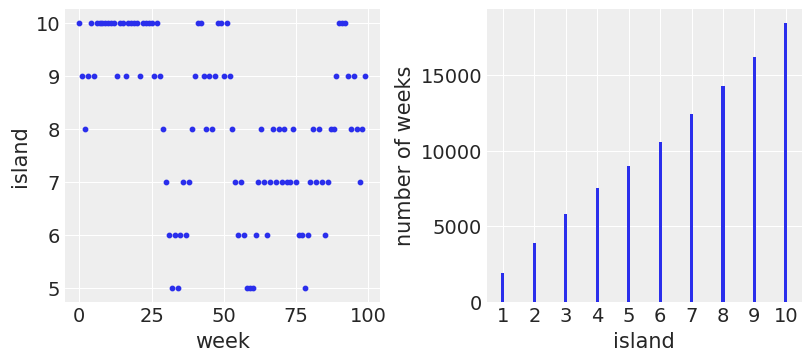

In [4]:
# Figure 9.2
_, axs = plt.subplots(1, 2, figsize=[8, 3.5], constrained_layout=True)

ax0, ax1 = axs

nplot = 100
ax0.scatter(range(nplot), positions[:nplot], s=10)
ax0.set_ylabel("island")
ax0.set_xlabel("week")

counts, _ = np.histogram(positions, bins=10)
ax1.bar(range(10), counts, width=0.1)
ax1.set_ylabel("number of weeks")
ax1.set_xlabel("island")
ax1.set_xticks(range(10))
ax1.set_xticklabels(range(1, 11));

#### Code 9.4

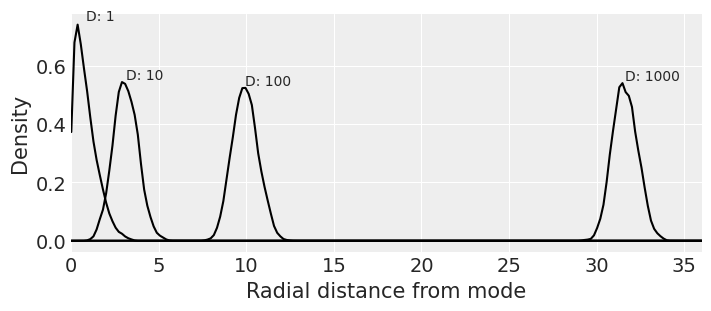

In [14]:
def rad_dist(Y):
    return np.sqrt(np.sum(Y**2))


fig, ax = plt.subplots(1, 1, figsize=[7, 3])
xvar = np.linspace(0, 36, 200)

# the book code is wrapped in a loop to reproduce Figure 9.4
for D in [1, 10, 100, 1000]:
    T = int(1e3)
    Y = stats.multivariate_normal(np.zeros(D), np.identity(D)).rvs(T)

    Rd = list(map(rad_dist, Y))

    kde = stats.gaussian_kde(Rd)
    yvar = kde(xvar)
    ax.plot(xvar, yvar, color="k")

    ax.text(np.mean(Rd), np.max(yvar) * 1.02, f"D: {D}")

ax.set_xlim(0, 36)
ax.set_xlabel("Radial distance from mode")
ax.set_ylabel("Density");

#### Code 9.5

In [15]:
def calc_U(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux = q

    U = (
        np.sum(stats.norm.logpdf(y, loc=muy, scale=1))
        + np.sum(stats.norm.logpdf(x, loc=mux, scale=1))
        + stats.norm.logpdf(muy, loc=a, scale=b)
        + stats.norm.logpdf(mux, loc=k, scale=d)
    )

    return -U

#### Code 9.6

In [16]:
# gradient function
# need vector of partial derivatives of U with respect to vector q
def calc_U_gradient(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux = q

    G1 = np.sum(y - muy) + (a - muy) / b**2  # dU/dmuy
    G2 = np.sum(x - mux) + (k - mux) / b**2  # dU/dmux

    return np.array([-G1, -G2])

#### Code 9.8 - 9.10

9.7 uses the function defined here, so is below

In [17]:
def HMC2(U, grad_U, epsilon, L, current_q, x, y):
    q = current_q
    p = np.random.normal(loc=0, scale=1, size=len(q))  # random flick - p is momentum
    current_p = p
    # Make a half step for momentum at the beginning
    p -= epsilon * grad_U(x, y, q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = np.full((L + 1, len(q)), np.nan)
    ptraj = qtraj.copy()
    qtraj[0, :] = current_q
    ptraj[0, :] = p

    # Code 9.9 starts here
    # Alternate full steps for position and momentum
    for i in range(L):
        q += epsilon * p  # Full step for the position
        qtraj[i + 1, :] = q
        # Make a full step for the momentum, except at the end of trajectory
        if i != L - 1:
            p -= epsilon * grad_U(x, y, q)
            ptraj[i + 1, :] = p

    # Make a half step for momentum at the end
    p -= epsilon * grad_U(x, y, q) / 2
    ptraj[L, :] = p
    # Negate momentum at end of trajectory to make the proposal symmetric
    p *= -1
    # Evaluate potential and kinetic energies sat start and end of trajectory
    current_U = U(x, y, current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(x, y, q)
    proposed_K = np.sum(p**2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = False
    if np.random.uniform() < np.exp(current_U - proposed_U + current_U - proposed_K):
        new_q = q  # accept
        accept = True
    else:
        new_q = current_q  # reject

    return dict(q=new_q, traj=qtraj, ptraj=ptraj, accept=accept)

#### Code 9.7

This code expands upon 9.7 to produce both panels in the top row of Figure 9.6

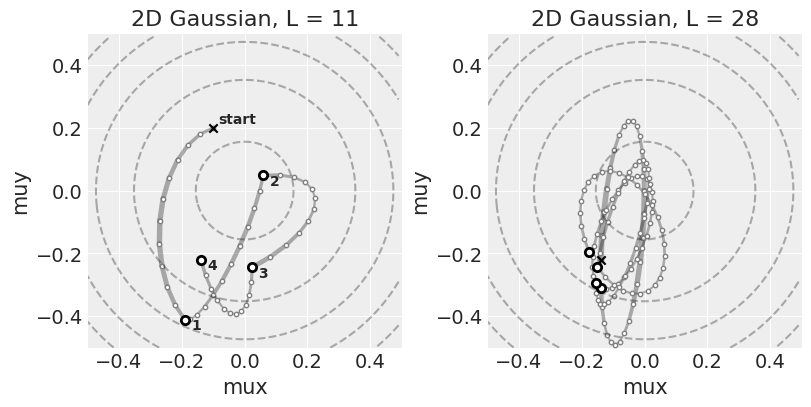

In [18]:
np.random.seed(42)

# test data
real = stats.multivariate_normal([0, 0], np.identity(2))
x, y = real.rvs(50).T

Q = {}
Q["q"] = np.array([-0.1, 0.2])
pr = 0.5
step = 0.03
# L = 11  # 0.03 / 28 for U-turns -- 11 for working example
n_samples = 4

_, axs = plt.subplots(1, 2, figsize=[8, 6], constrained_layout=True)

for L, ax in zip([11, 28], axs):
    ax.scatter(*Q["q"], color="k", marker="x", zorder=3)
    if L == 11:
        ax.text(*Q["q"] + 0.015, "start", weight="bold")
    for i in range(n_samples):
        Q = HMC2(calc_U, calc_U_gradient, step, L, Q["q"], x, y)
        ax.scatter(*Q["q"], color="w", marker="o", edgecolor="k", lw=2, zorder=3)
        if n_samples < 10:
            for j in range(L):
                K0 = np.sum(Q["ptraj"][j, :] ** 2) / 2  # kinetic energy
                ax.plot(
                    Q["traj"][j : j + 2, 0],
                    Q["traj"][j : j + 2, 1],
                    color="k",
                    lw=1 + 1 * K0,
                    alpha=0.3,
                    zorder=1,
                )
            ax.scatter(*Q["traj"].T, facecolor="w", edgecolor="gray", lw=1, zorder=2, s=10)
            if L == 11:
                ax.text(*Q["q"] + [0.02, -0.03], f"{i + 1}", weight="bold")

    ax.set_title(f"2D Gaussian, L = {L}")
    ax.set_xlabel("mux")
    ax.set_ylabel("muy")

    # draw background contours based on real probability defined above
    ax.set_xlim(-pr, pr)
    ax.set_ylim(-pr, pr)
    xs, ys = np.mgrid[-pr:pr:0.01, -pr:pr:0.01]
    p = real.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 4, colors=[(0, 0, 0, 0.3)])
    ax.set_aspect(1);

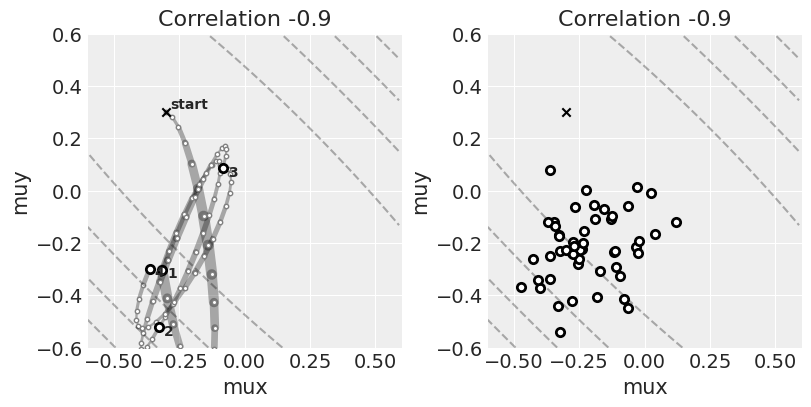

In [19]:
# Figure 9.6 (bottom row) with correlated data

np.random.seed()

# test data
realc = stats.multivariate_normal([0, 0], [[1, -0.9], [-0.9, 1]])  # generate correlated data
x, y = real.rvs(50).T

Q = {}
pr = 0.6
step = 0.03
L = 21  # 28 for U-turns -- 11 for working example

_, axs = plt.subplots(1, 2, figsize=[8, 4], constrained_layout=True)

for n_samples, ax in zip([4, 50], axs):
    Q["q"] = np.array([-0.3, 0.3])

    ax.scatter(*Q["q"], color="k", marker="x", zorder=3)
    if n_samples == 4:
        ax.text(*Q["q"] + 0.015, "start", weight="bold")
    for i in range(n_samples):
        Q = HMC2(calc_U, calc_U_gradient, step, L, Q["q"], x, y)
        ax.scatter(*Q["q"], color="w", marker="o", edgecolor="k", lw=2, zorder=3)
        if n_samples < 10:
            for j in range(L):
                K0 = np.sum(Q["ptraj"][j, :] ** 2) / 2  # kinetic energy
                ax.plot(
                    Q["traj"][j : j + 2, 0],
                    Q["traj"][j : j + 2, 1],
                    color="k",
                    lw=1 + 1 * K0,
                    alpha=0.3,
                    zorder=1,
                )
            if Q["accept"]:
                c = "w"
            else:
                c = "k"
            ax.scatter(*Q["traj"].T, facecolor=c, edgecolor="gray", lw=1, zorder=2, s=10)
            if n_samples == 4:
                ax.text(*Q["q"] + [0.02, -0.03], f"{i + 1}", weight="bold")

    ax.set_title(f"Correlation -0.9")
    ax.set_xlabel("mux")
    ax.set_ylabel("muy")

    # draw background contours based on real probability defined above
    ax.set_xlim(-pr, pr)
    ax.set_ylim(-pr, pr)
    xs, ys = np.mgrid[-pr:pr:0.01, -pr:pr:0.01]
    p = realc.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 5, colors=[(0, 0, 0, 0.3)])
    ax.set_aspect(1);

The correlated case doens't work as well as the uncorrelated case, compared to the book. We're not reproducing the sinusoid trajectories that are shown in the book, so it's possible that there was some underlying change in the likelihood functions?The book doesn't provide code or parameters used to recreate these plots, so we're guessing blind here.

#### Code 9.11

In [20]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

d["log_gdp"] = np.log(d["rgdppc_2000"])

dd = d.dropna(subset=["log_gdp"])
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

#### Code 9.12-9.18

By using PyMC we are already doing everything in these code blocks (No-Uturn sampling, parallell processing).

To translate the results of `summary` to `rethinking`'s `precis`:

 - `n_eff = ess_mean`
 - `Rhat4 = r_hat`

In [21]:
cid = pd.Categorical(dd["cont_africa"])

with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    m_8_3_trace = pm.sample()

az.summary(m_8_3_trace, kind="all", round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a[0]   1.05  0.01      1.04       1.07        0.0      0.0   5805.04   
a[1]   0.88  0.02      0.86       0.91        0.0      0.0   4947.04   
b[0]  -0.14  0.06     -0.23      -0.05        0.0      0.0   6793.29   
b[1]   0.13  0.08      0.01       0.25        0.0      0.0   5472.04   
sigma  0.11  0.01      0.10       0.12        0.0      0.0   4586.51   

       ess_tail  r_hat  
a[0]    3017.10    1.0  
a[1]    3417.75    1.0  
b[0]    3547.06    1.0  
b[1]    3333.37    1.0  
sigma   3163.12    1.0

#### Code 9.19

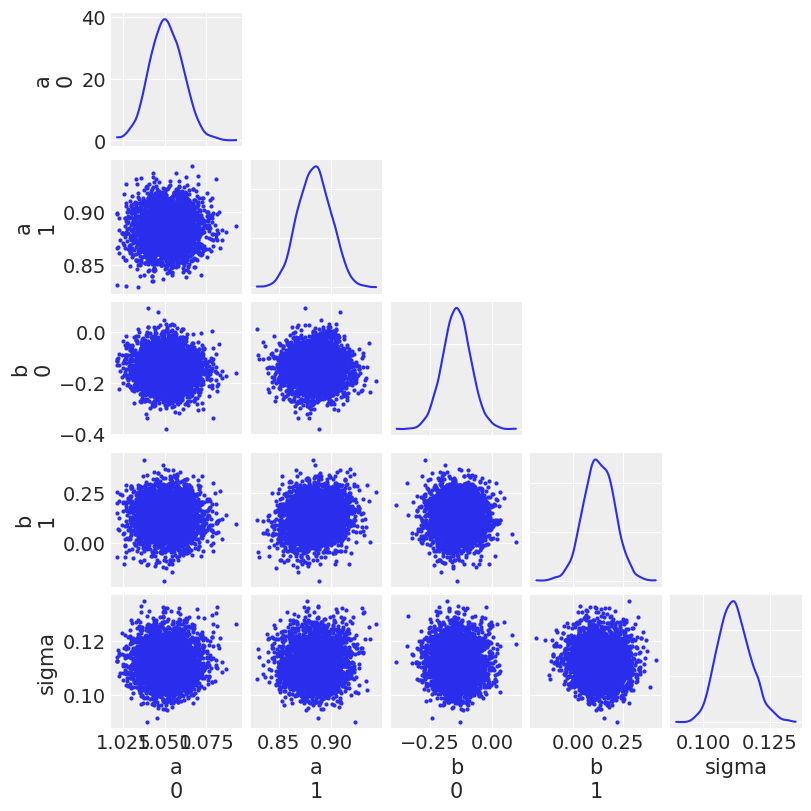

In [22]:
az.plot_pair(m_8_3_trace, figsize=[8, 8], marginals=True);

#### Code 9.20

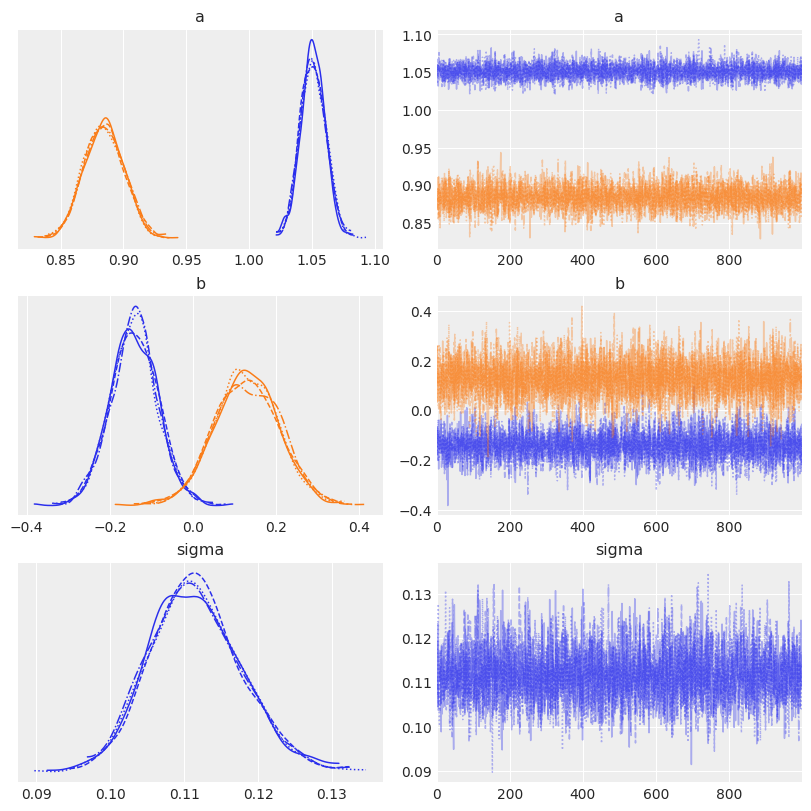

In [23]:
az.plot_trace(m_8_3_trace, figsize=[8, 8]);

#### Code 9.21

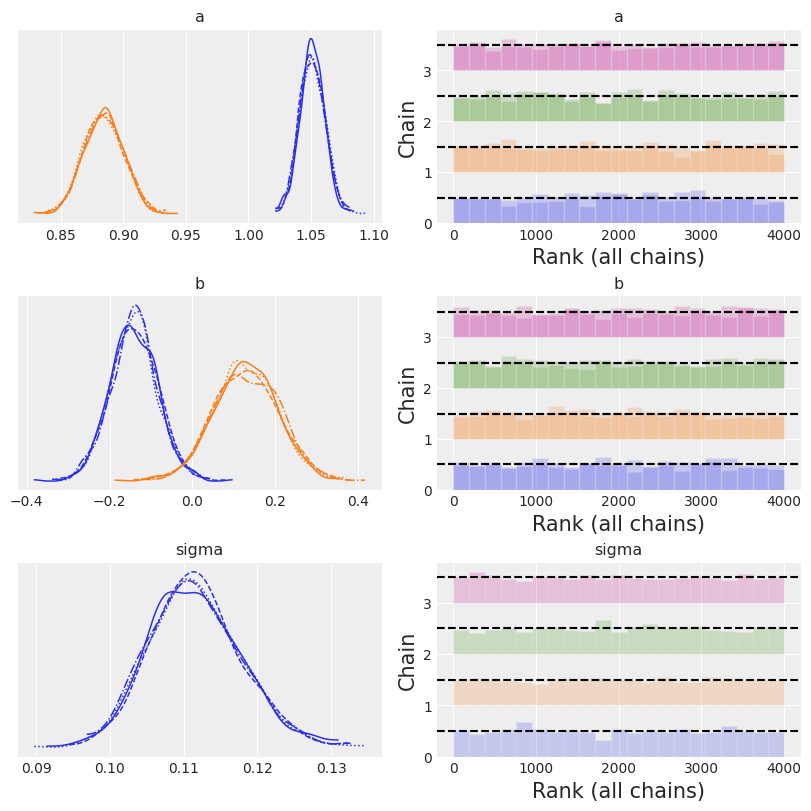

In [24]:
az.plot_trace(m_8_3_trace, figsize=[8, 8], kind="rank_bars");

#### Code 9.22

In [25]:
y = np.array([-1, 1])

with pm.Model() as m_9_2:
    alpha = pm.Normal("alpha", 0, 1000)

    mu = alpha
    sigma = pm.Exponential("sigma", 0.0001)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_2_trace = pm.sample(chains=3)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 10 seconds.
There were 589 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Code 9.23

In [26]:
az.summary(m_9_2_trace, round_to=2)

mean       sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  -18.91   358.92   -477.04     533.39      16.88    30.12    501.89   
sigma  611.86  1609.24     10.77    1368.83      78.10   313.05     38.66   

       ess_tail  r_hat  
alpha    375.33   1.02  
sigma     19.03   1.07

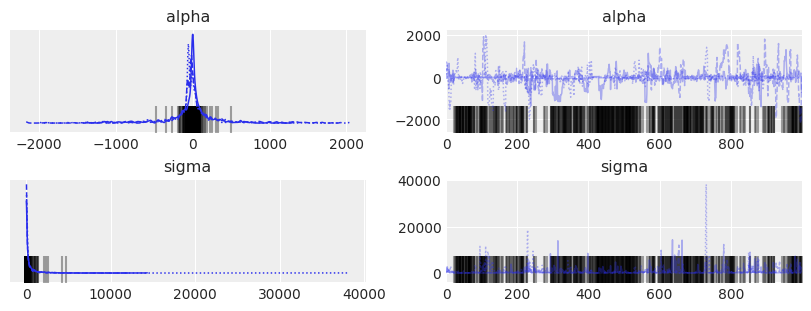

In [27]:
# Figure 9.9 (top)
az.plot_trace(m_9_2_trace, figsize=[8, 3]);

#### Code 9.24

In [28]:
with pm.Model() as m_9_3:
    alpha = pm.Normal("alpha", 1, 10)

    mu = alpha
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_3_trace = pm.sample(chains=3)

az.summary(m_9_3_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 9 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha -0.02  1.22     -2.05       1.83       0.04     0.05   1212.69   
sigma  1.57  0.80      0.52       2.58       0.03     0.02    863.35   

       ess_tail  r_hat  
alpha    836.67   1.01  
sigma   1158.37   1.01

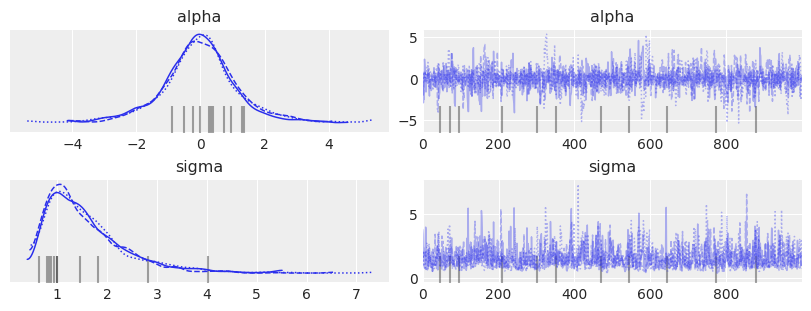

In [29]:
# Figure 9.9 (bottom)
az.plot_trace(m_9_3_trace, figsize=[8, 3]);

Sampling: [alpha, sigma]


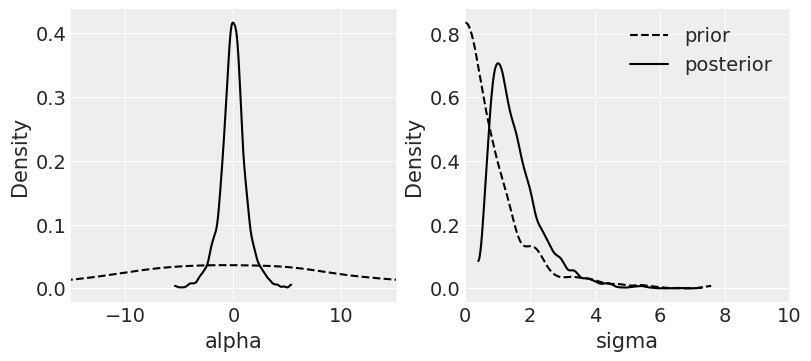

In [30]:
# Figure 9.10
with m_9_3:
    m_9_3_prior = az.extract_dataset(
        pm.sample_prior_predictive(var_names=["alpha", "sigma"])["prior"]
    )
    m_9_3_post = az.extract_dataset(m_9_3_trace["posterior"], var_names=["alpha", "sigma"])

_, axs = plt.subplots(1, 2, figsize=[8, 3.5], constrained_layout=True)
ax0, ax1 = axs

az.plot_kde(m_9_3_prior["alpha"].to_numpy(), ax=ax0, plot_kwargs={"color": "k", "ls": "dashed"})
az.plot_kde(m_9_3_post["alpha"].to_numpy(), ax=ax0, plot_kwargs={"color": "k"})
ax0.set_xlim(-15, 15)
ax0.set_xlabel("alpha")

az.plot_kde(
    m_9_3_prior["sigma"].to_numpy(),
    ax=ax1,
    plot_kwargs={"color": "k", "ls": "dashed"},
    label="prior",
)
az.plot_kde(m_9_3_post["sigma"].to_numpy(), ax=ax1, plot_kwargs={"color": "k"}, label="posterior")
ax1.legend()
ax1.set_xlim(0, 10)
ax1.set_xlabel("sigma")

for ax in axs:
    ax.set_ylabel("Density");

#### Code 9.25

In [31]:
y = np.random.normal(loc=0, scale=1, size=100)

#### Code 9.26

In [32]:
with pm.Model() as m_9_4:
    a1 = pm.Normal("a1", 0, 1000)
    a2 = pm.Normal("a2", 0, 1000)

    mu = a1 + a2
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_4_trace = pm.sample(chains=3)

az.summary(m_9_4_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a1, a2, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 676 draw iterations (3_000 + 2_028 draws total) took 4681 seconds.
There were 409 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean      sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a1     87.08  669.20   -810.56     684.42     373.58   113.87      4.29   
a2    -87.08  669.21   -684.51     810.48     373.58   113.87      4.27   
sigma   0.83    0.06      0.78       0.93       0.02     0.01      5.02   

       ess_tail  r_hat  
a1        13.12   1.96  
a2        14.95   1.96  
sigma     36.13   1.92

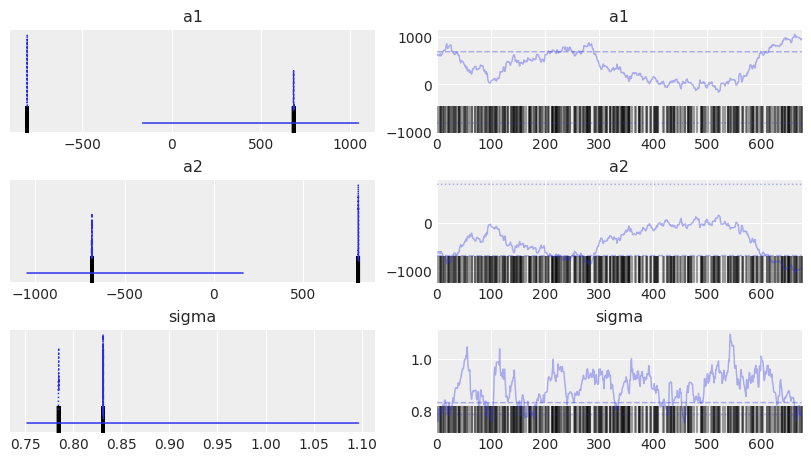

In [ ]:
# Figure 9.11 (top half)
az.plot_trace(m_9_4_trace, figsize=[8, 4.5]);

#### Code 9.27

In [35]:
with pm.Model() as m_9_5:
    a1 = pm.Normal("a1", 0, 10)
    a2 = pm.Normal("a2", 0, 10)

    mu = a1 + a2
    sigma = pm.Exponential("sigma", 1)

    yp = pm.Normal("y", mu, sigma, observed=y)

    m_9_5_trace = pm.sample(chains=3)

az.summary(m_9_5_trace, round_to=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a1, a2, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 18850 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a1     0.13  6.84    -10.90      10.91       0.24     0.16    813.67   
a2    -0.14  6.84    -10.87      10.96       0.24     0.16    812.14   
sigma  0.86  0.06      0.76       0.95       0.00     0.00   1188.43   

       ess_tail  r_hat  
a1      1102.83   1.01  
a2      1063.74   1.01  
sigma   1108.77   1.00

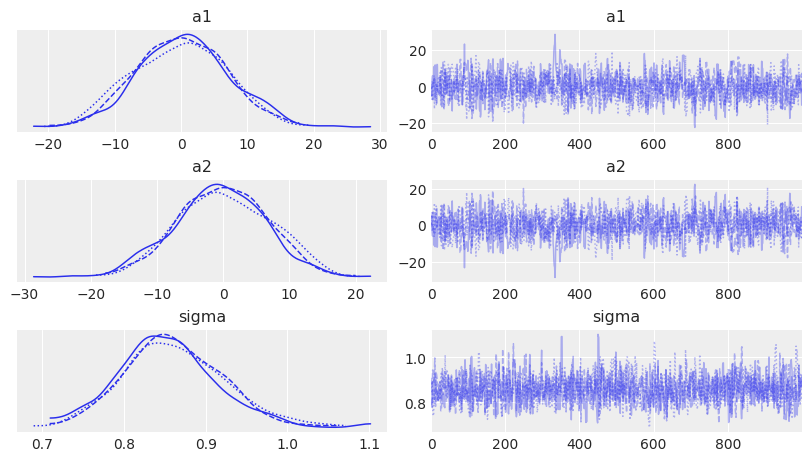

In [36]:
# Figure 9.11 (bottom half)
az.plot_trace(m_9_5_trace, figsize=[8, 4.5]);

9E1.  Re-estimate the terrain ruggedness model from the chapter, but now using a uniform prior for the standard deviation, sigma. The uniform prior should be dunif(0,1). Use ulam to estimate the posterior. Does the different prior have any detectible influence on the posterior distribution of sigma? Why or why not?

In [38]:
df_rugged = pd.read_csv("./End_of_chapter_problems/data/rugged.csv", delimiter=";")
df_rugged.shape

(234, 51)

In [39]:
# get the complete cases
df_rugged = df_rugged.dropna(axis=0, subset=["rgdppc_2000"])
df_rugged.shape

(170, 51)

In [40]:
# lets standardise the variables like how he does in the book
df_rugged["log_gdp"] = np.log(df_rugged["rgdppc_2000"])
df_rugged["s_log_gdp"] = df_rugged["log_gdp"] / np.mean(df_rugged["log_gdp"])
df_rugged["s_rugged"] = df_rugged["rugged"] / np.max(df_rugged["rugged"])

In [43]:
with pm.Model() as m8_3:
    a = pm.Normal("a", 1, 0.1, shape=2)
    b = pm.Normal("b", 1, 0.3, shape=2)
    sigma = pm.Exponential("sigma", 1)
    x = pm.Data("x", df_rugged.s_rugged)
    cid = pm.intX(pm.Data("cid", df_rugged.cont_africa))
    mu = pm.Deterministic("mu", a[cid] + b[cid] * (x - 0.215))
    l_gdp = pm.Normal("l_gdp", mu=mu, sigma=sigma, observed=df_rugged.s_log_gdp)
    m8_3_samples = pm.sample(draws=250, chains=4, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 89 seconds.


In [44]:
with pm.Model() as m8_3_sigma:
    a = pm.Normal("a", 1, 0.1, shape=2)
    b = pm.Normal("b", 1, 0.3, shape=2)
    sigma = pm.Uniform('sigma', 0, 1)
    x = pm.Data("x", df_rugged.s_rugged)
    cid = pm.intX(pm.Data("cid", df_rugged.cont_africa))
    mu = pm.Deterministic("mu", a[cid] + b[cid] * (x - 0.215))
    l_gdp = pm.Normal("l_gdp", mu=mu, sigma=sigma, observed=df_rugged.s_log_gdp)
    m8_3_sigma_samples = pm.sample(draws=250, chains=4, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 65 seconds.


<Axes: title={'center': 'sigma'}>

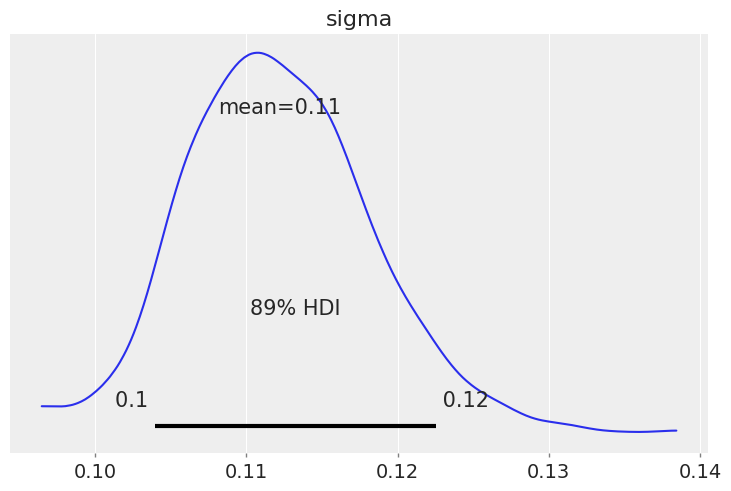

In [48]:
az.plot_posterior(m8_3_samples, var_names=['sigma'])

<Axes: title={'center': 'sigma'}>

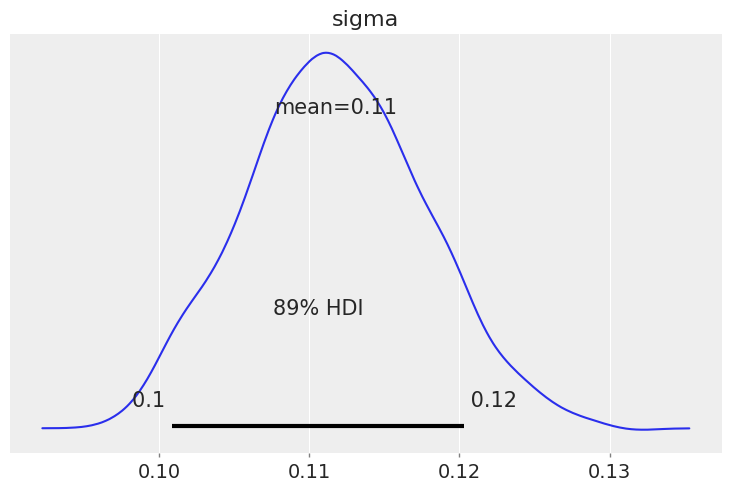

In [49]:
az.plot_posterior(m8_3_sigma_samples, var_names=['sigma'])

9E2.  Modify the terrain ruggedness model again. This time, change the prior for b[cid] to dexp(0.3). What does this do to the posterior distribution? Can you explain it?

In [50]:
with pm.Model() as m8_3_exp:
    a = pm.Normal("a", 1, 0.1, shape=2)
    b = pm.Exponential("b", 0.3, shape=2)
    sigma = pm.Exponential("sigma", 1)
    x = pm.Data("x", df_rugged.s_rugged)
    cid = pm.intX(pm.Data("cid", df_rugged.cont_africa))
    mu = pm.Deterministic("mu", a[cid] + b[cid] * (x - 0.215))
    l_gdp = pm.Normal("l_gdp", mu=mu, sigma=sigma, observed=df_rugged.s_log_gdp)
    m8_3_exp_samples = pm.sample(draws=250, chains=4, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 127 seconds.


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'a\n0'}>,
        <Axes: title={'center': 'a\n1'}>],
       [<Axes: title={'center': 'b\n0'}>,
        <Axes: title={'center': 'b\n1'}>, <Axes: >]], dtype=object)

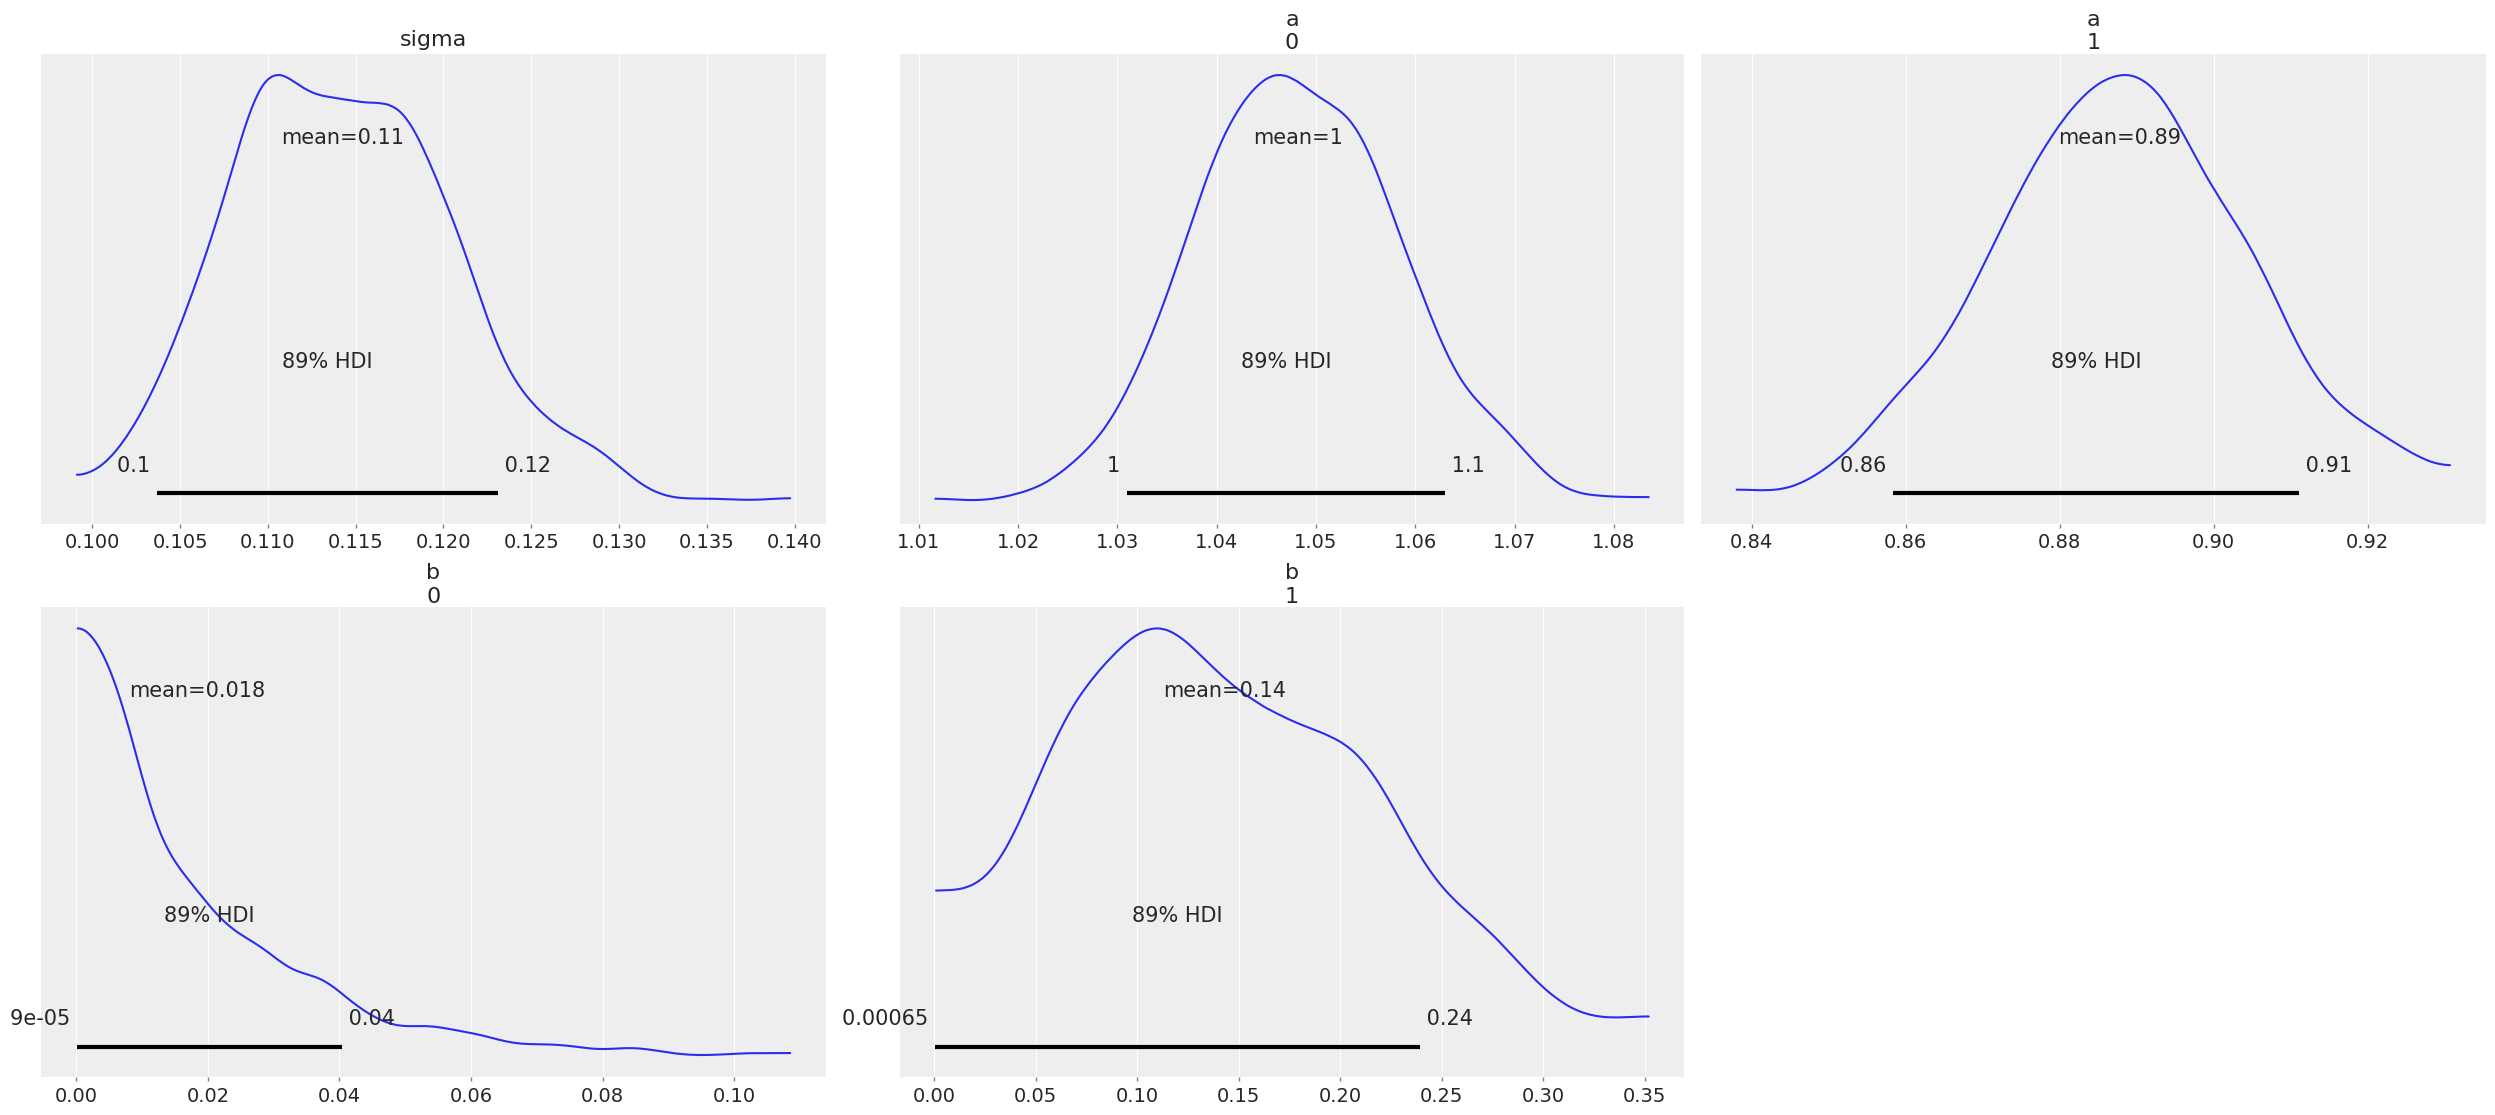

In [52]:
az.plot_posterior(m8_3_exp_samples, var_names=['sigma', 'a', 'b'])

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'a\n0'}>,
        <Axes: title={'center': 'a\n1'}>],
       [<Axes: title={'center': 'b\n0'}>,
        <Axes: title={'center': 'b\n1'}>, <Axes: >]], dtype=object)

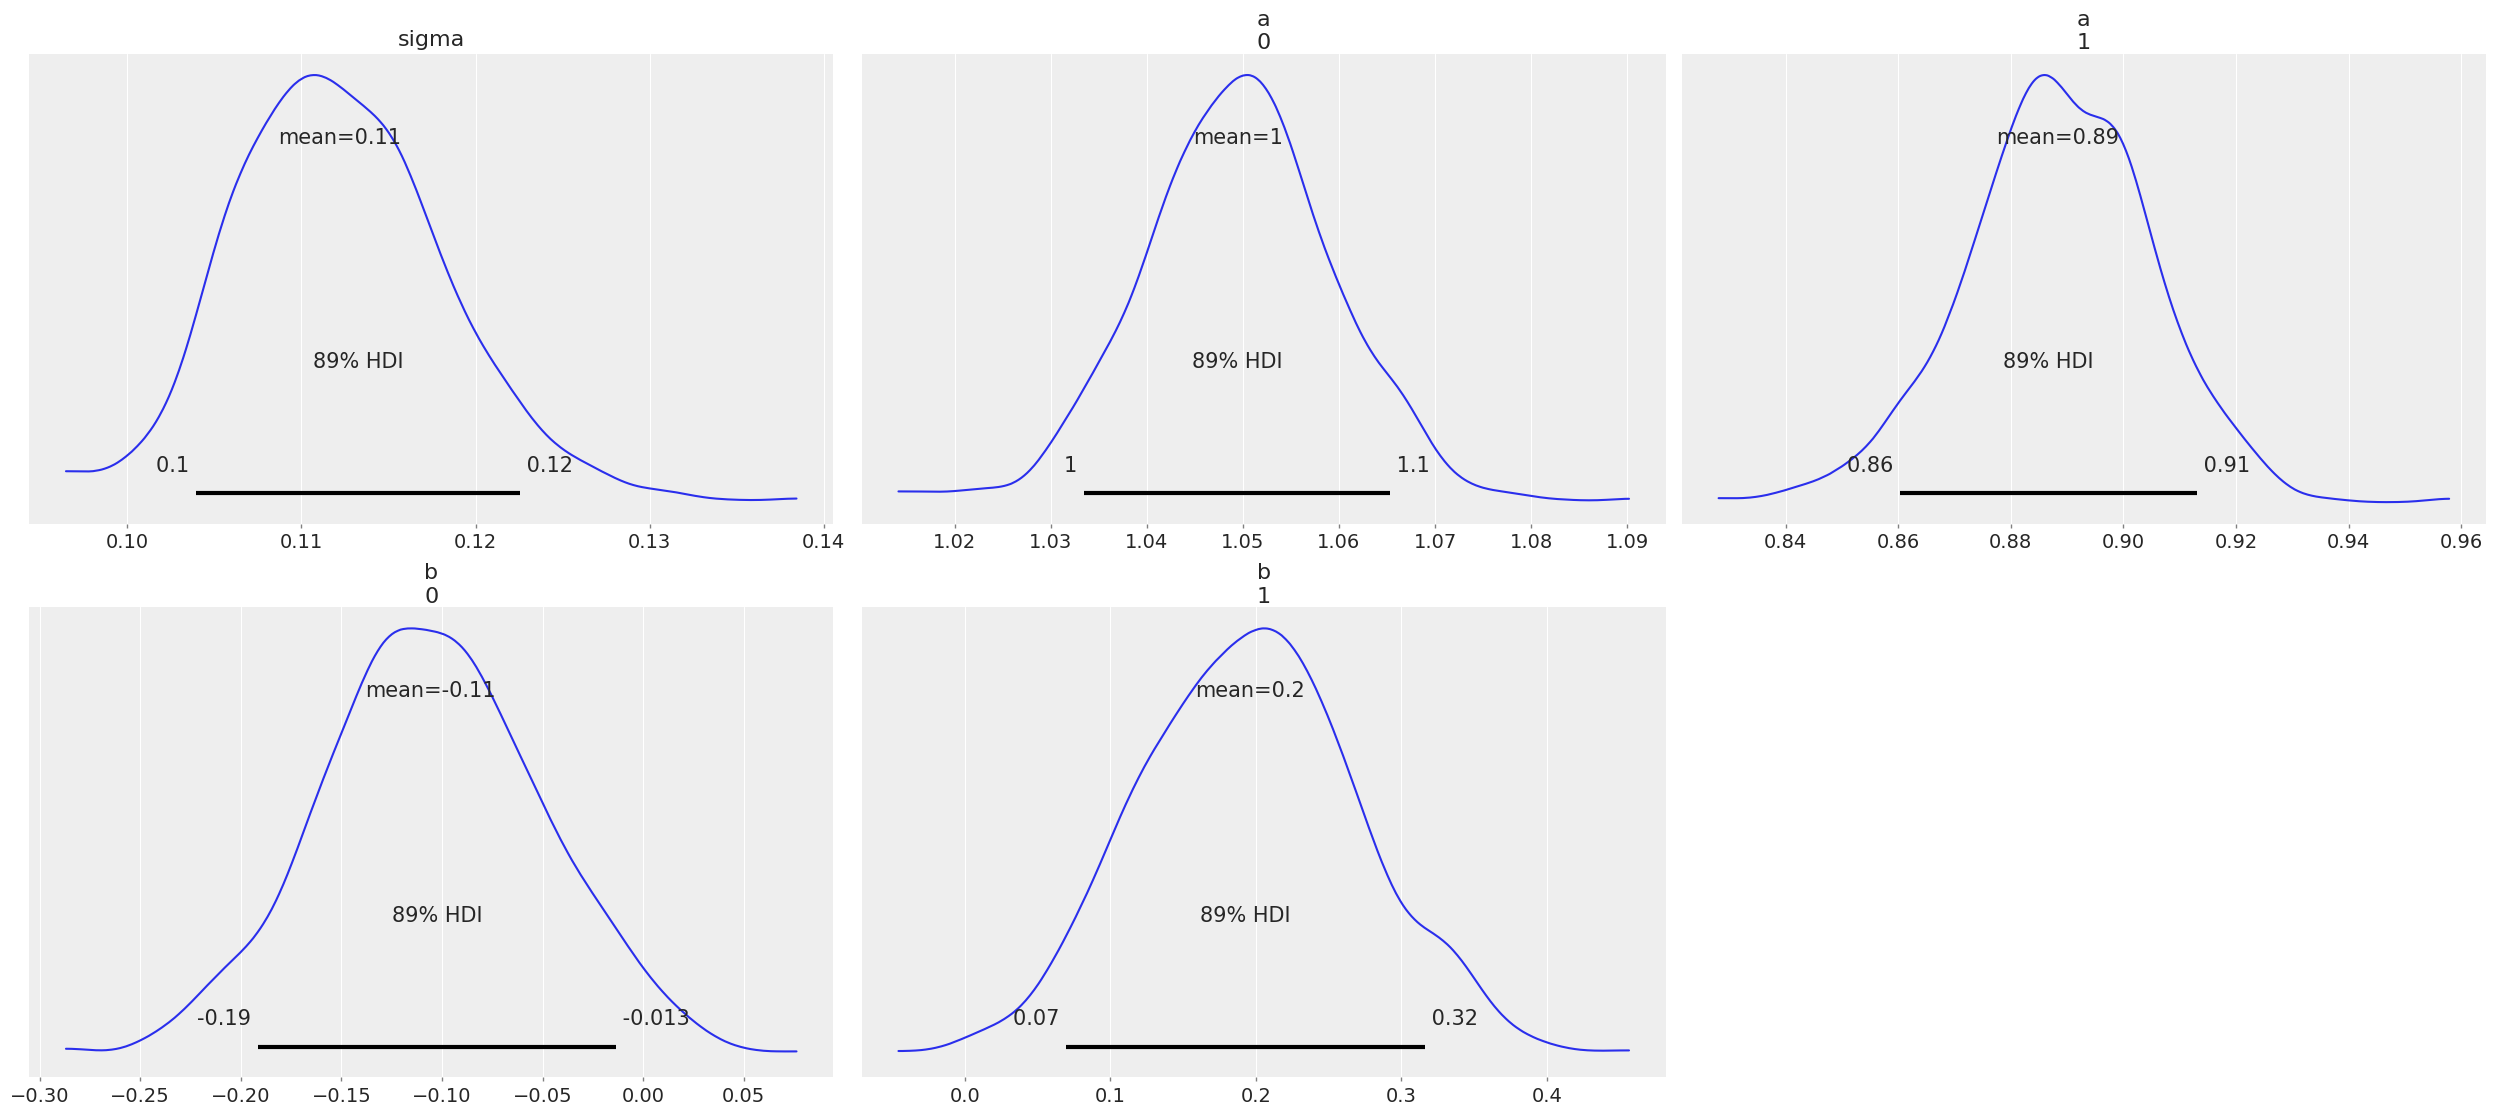

In [53]:
az.plot_posterior(m8_3_samples, var_names=['sigma', 'a', 'b'])

Exponential constrains parameters to be positive

9E3.  Re-estimate one of the Stan models from the chapter, but at different numbers of warmup iterations. Be sure to use the same number of sampling iterations in each case. Compare the n_eff values. How much warmup is enough?

In [54]:
with m8_3:
    tune10 = pm.sample(draws=1000, chains=4, return_inferencedata=True, tune=10)
    tune100 = pm.sample(draws=1000, chains=4, return_inferencedata=True, tune=100)
    tune1000 = pm.sample(draws=1000, chains=4, return_inferencedata=True, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 10 tune and 1_000 draw iterations (40 + 4_000 draws total) took 91 seconds.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 137 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


In [69]:
az.summary(tune10)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a[0]     1.050  0.010     1.033      1.065      0.000    0.000    2434.0   
a[1]     0.890  0.017     0.862      0.915      0.000    0.000    2294.0   
b[0]    -0.103  0.060    -0.200     -0.014      0.002    0.002     623.0   
b[1]     0.199  0.078     0.076      0.321      0.004    0.003     451.0   
sigma    0.112  0.007     0.101      0.121      0.000    0.000     516.0   
...        ...    ...       ...        ...        ...      ...       ...   
mu[165]  1.044  0.011     1.027      1.060      0.000    0.000    1924.0   
mu[166]  1.033  0.014     1.012      1.054      0.000    0.000     986.0   
mu[167]  0.903  0.018     0.876      0.934      0.000    0.000    1580.0   
mu[168]  0.864  0.018     0.835      0.892      0.000    0.000    1681.0   
mu[169]  0.885  0.016     0.859      0.911      0.000    0.000    2477.0   

         ess_tail  r_hat  
a[0]       1820.0   1.00  
a[1]       1618.0   1.00  
b[0]        713.0   1.00  
b[1]        645.0   1.02  
sigma       614.0   1.01  
...           ...    ...  
mu[165]    1468.0   1.00  
mu[166]    1098.0   1.00  
mu[167]    1706.0   1.00  
mu[168]    1567.0   1.00  
mu[169]    1594.0   1.00  

[175 rows x 9 columns]

In [56]:
az.summary(tune100)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a[0]     1.050  0.010     1.033      1.065      0.000    0.000    4846.0   
a[1]     0.889  0.016     0.864      0.914      0.000    0.000    4287.0   
b[0]    -0.107  0.055    -0.194     -0.018      0.001    0.001    2665.0   
b[1]     0.198  0.074     0.093      0.329      0.002    0.001    1702.0   
sigma    0.112  0.006     0.102      0.122      0.000    0.000    2202.0   
...        ...    ...       ...        ...        ...      ...       ...   
mu[165]  1.044  0.010     1.028      1.061      0.000    0.000    4788.0   
mu[166]  1.033  0.013     1.012      1.053      0.000    0.000    3950.0   
mu[167]  0.903  0.018     0.875      0.930      0.000    0.000    3414.0   
mu[168]  0.864  0.017     0.836      0.891      0.000    0.000    3447.0   
mu[169]  0.885  0.016     0.860      0.909      0.000    0.000    4425.0   

         ess_tail  r_hat  
a[0]       2883.0   1.00  
a[1]       2976.0   1.00  
b[0]       2263.0   1.01  
b[1]       1855.0   1.00  
sigma      2316.0   1.00  
...           ...    ...  
mu[165]    3328.0   1.00  
mu[166]    3568.0   1.00  
mu[167]    2938.0   1.00  
mu[168]    3073.0   1.00  
mu[169]    2570.0   1.00  

[175 rows x 9 columns]

In [57]:
az.summary(tune1000)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a[0]     1.050  0.010     1.034      1.068      0.000    0.000    6749.0   
a[1]     0.889  0.016     0.865      0.914      0.000    0.000    4720.0   
b[0]    -0.107  0.056    -0.195     -0.019      0.001    0.001    5857.0   
b[1]     0.196  0.075     0.078      0.316      0.001    0.001    5562.0   
sigma    0.112  0.006     0.102      0.121      0.000    0.000    4778.0   
...        ...    ...       ...        ...        ...      ...       ...   
mu[165]  1.044  0.010     1.027      1.061      0.000    0.000    7306.0   
mu[166]  1.033  0.013     1.012      1.053      0.000    0.000    7530.0   
mu[167]  0.903  0.018     0.873      0.929      0.000    0.000    4267.0   
mu[168]  0.864  0.017     0.837      0.891      0.000    0.000    6340.0   
mu[169]  0.885  0.016     0.859      0.908      0.000    0.000    4956.0   

         ess_tail  r_hat  
a[0]       3097.0    1.0  
a[1]       3247.0    1.0  
b[0]       3194.0    1.0  
b[1]       3379.0    1.0  
sigma      3066.0    1.0  
...           ...    ...  
mu[165]    2908.0    1.0  
mu[166]    3308.0    1.0  
mu[167]    3160.0    1.0  
mu[168]    3258.0    1.0  
mu[169]    3139.0    1.0  

[175 rows x 9 columns]

In [61]:
az.summary(tune1000, var_names=["a"], round_to=2, kind="all", stat_focus='mean')

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]  1.05  0.01      1.03       1.07        0.0      0.0   6749.14   3097.50   
a[1]  0.89  0.02      0.86       0.91        0.0      0.0   4719.86   3247.29   

      r_hat  
a[0]    1.0  
a[1]    1.0

9H1.  Run the model below and then inspect the posterior distribution and explain what it is accomplishing.

R code 9.28

mp <- ulam(

 alist(

  a ~ dnorm(0,1),

  b ~ dcauchy(0,1)

 ), data=list(y=1) , chains=1 )

Compare the samples for the parameters a and b. Can you explain the different trace plots? If you are unfamiliar with the Cauchy distribution, you should look it up. The key feature to attend to is that it has no expected value. Can you connect this fact to the trace plot?

In [80]:
with pm.Model() as m_strange:
    a = pm.Normal("a", 0, 1)
    b = pm.Cauchy("b", 0, 1)
    y = pm.Data("y", [1])
    m_strange_samples = pm.sample(draws=1000, chains=1, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [a, b]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [81]:
az.summary(m_strange_samples)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a -0.067   1.028    -1.808      1.414      0.079    0.049     174.0     246.0   
b -0.458  10.221    -5.173      4.306      0.450    3.995     477.0     215.0   

   r_hat  
a    NaN  
b    NaN

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

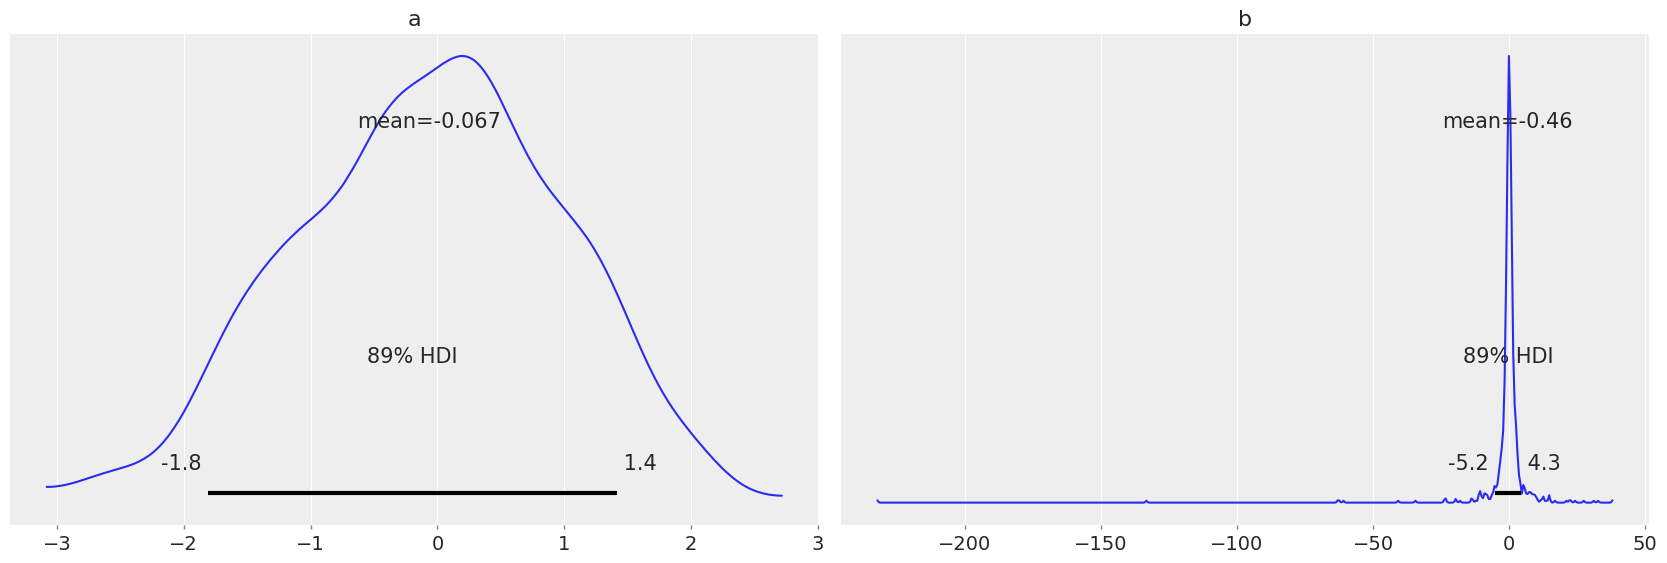

In [82]:
az.plot_posterior(m_strange_samples, var_names=['a', 'b'])

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

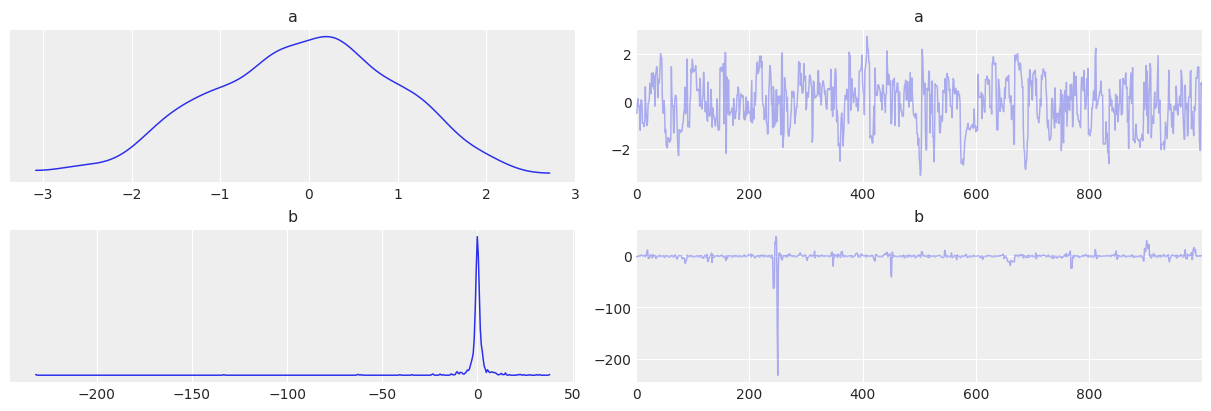

In [83]:
az.plot_trace(m_strange_samples)

Because of Cauchy distribution you have more extreme values more probable and thus there is some central tendency but very long tal (the more draws the more longer tail)

9H2.  Recall the divorce rate example from Chapter 5. Repeat that analysis, using ulam this time, fitting models m5.1, m5.2, and m5.3. Use compare to compare the models on the basis of WAIC or PSIS. To use WAIC or PSIS with ulam, you need add the argument log_log=TRUE. Explain the model comparison results.

In [87]:
import os
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")
data.shape

(50, 13)

In [88]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

In [89]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [90]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Sampling: [a, bA, divorce_rate_std, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [91]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Sampling: [a, bM, divorce_rate_std, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [92]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"].values + bA * data["MedianAgeMarriage_std"].values
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Sampling: [a, bA, bM, divorce_rate_std, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

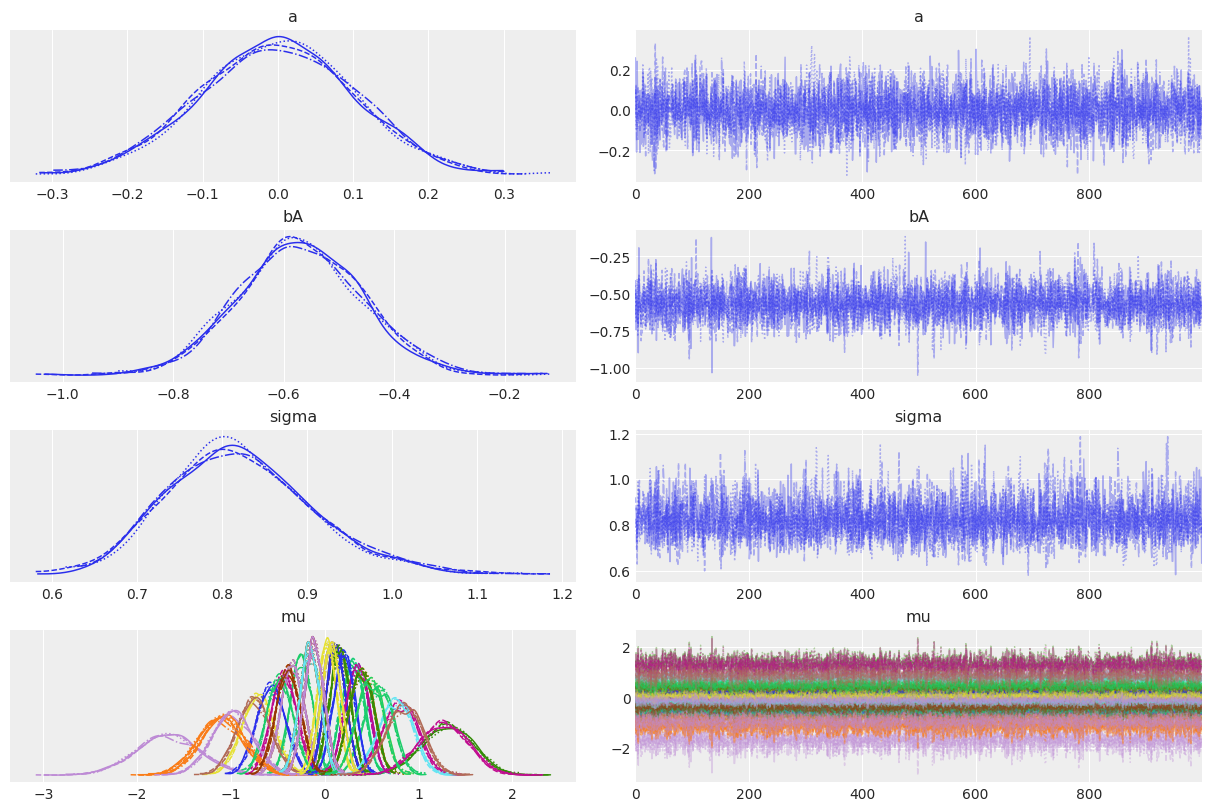

In [100]:
az.plot_trace(m_5_1_trace)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'bM'}>, <Axes: title={'center': 'bM'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

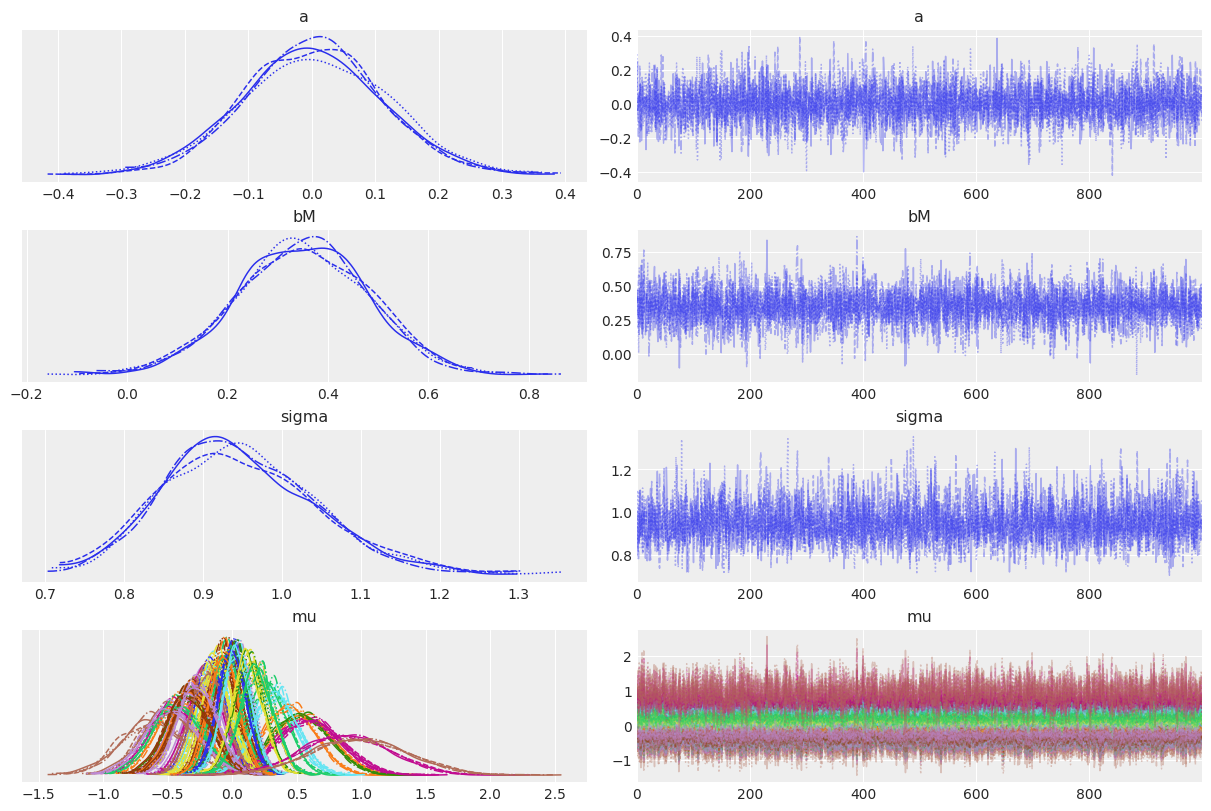

In [101]:
az.plot_trace(m_5_2_trace)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'bM'}>, <Axes: title={'center': 'bM'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

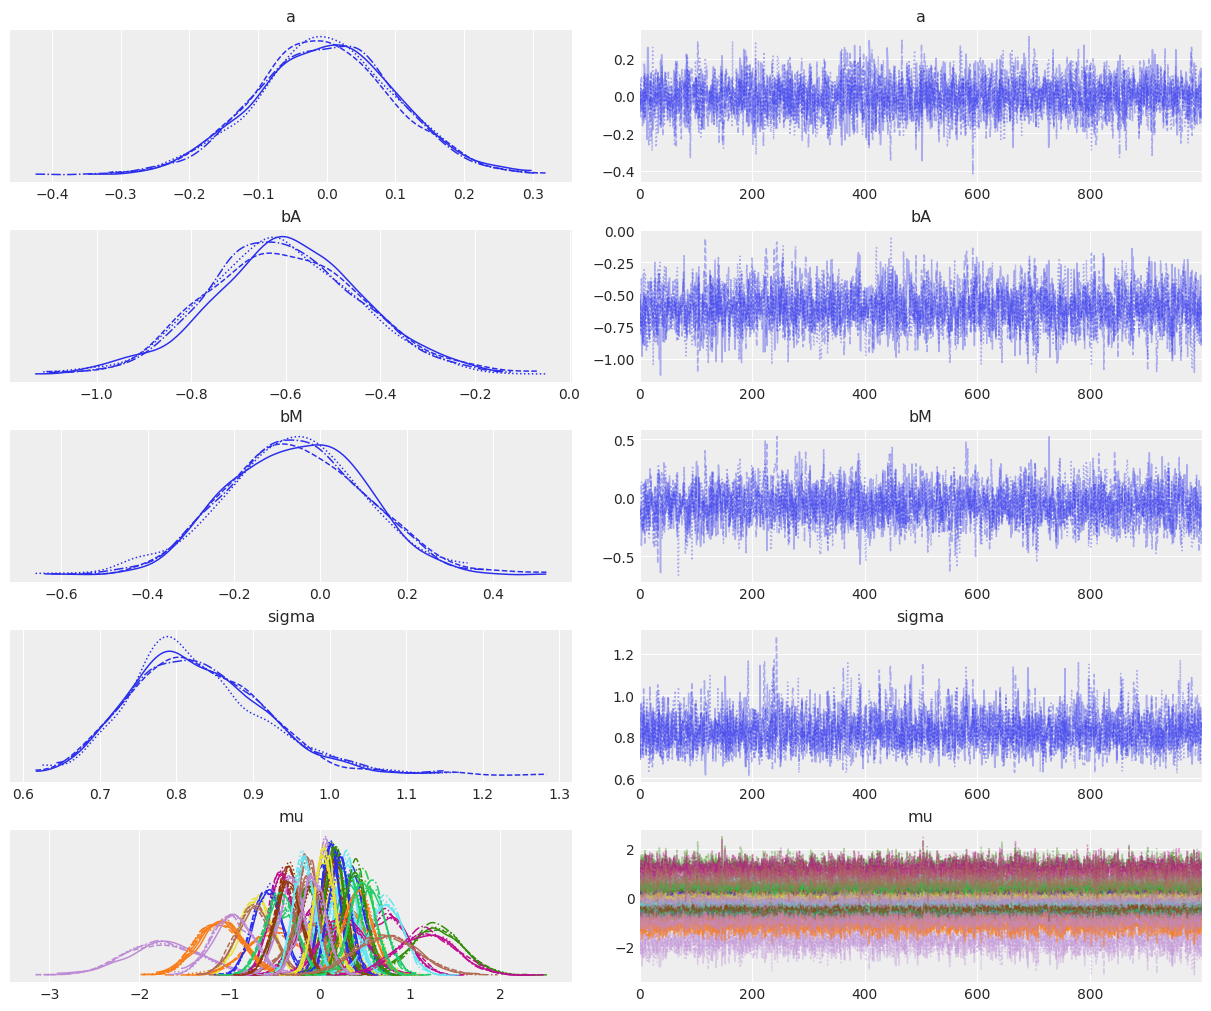

In [102]:
az.plot_trace(m_5_3_trace)

In [93]:
waic_m_5_1 = pm.compute_log_likelihood(m_5_1_trace, model=m_5_1)
waic_m_5_1 = pm.waic(waic_m_5_1)

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [94]:
waic_m_5_2 = pm.compute_log_likelihood(m_5_2_trace, model=m_5_2)
waic_m_5_2 = pm.waic(waic_m_5_2)

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [97]:
waic_m_5_3 = pm.compute_log_likelihood(m_5_3_trace, model=m_5_3)
waic_m_5_3 = pm.waic(waic_m_5_3)

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [95]:
waic_m_5_1

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -62.79     6.29
p_waic        3.55        -

There has been a warning during the calculation. Please check the results.

In [96]:
waic_m_5_2

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -69.60     4.89
p_waic        2.89        -

There has been a warning during the calculation. Please check the results.

In [98]:
waic_m_5_3

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -63.75     6.32
p_waic        4.70        -

There has been a warning during the calculation. Please check the results.

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior varianc

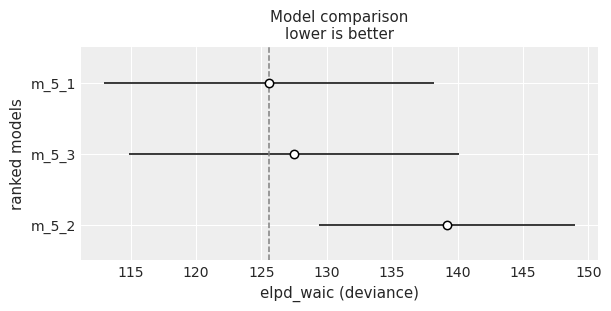

In [99]:
compare_df = az.compare(
    {
        "m_5_1": m_5_1_trace,
        "m_5_2": m_5_2_trace,
        "m_5_3": m_5_3_trace
    },
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
az.plot_compare(compare_df);

In [103]:
az.compare({"m5_1": m_5_1_trace, "m5_2": m_5_2_trace, "m5_3": m_5_3_trace}, scale="deviance")

rank    elpd_loo     p_loo  elpd_diff        weight         se  \
m5_1     0  125.676876  3.600632   0.000000  8.959258e-01  12.646948   
m5_3     1  127.640899  4.764605   1.964023  2.774700e-15  12.696479   
m5_2     2  139.240343  2.915827  13.563468  1.040742e-01   9.788618   

           dse  warning     scale  
m5_1  0.000000    False  deviance  
m5_3  0.708594    False  deviance  
m5_2  9.119061    False  deviance

It can be seen that model 5.1 and 5.3 perform similarly in making predictions out of sample. Model 5.2 does much worse than the other two with a much larger deviance. Models 5.1 and 5.3 both include the age of the participants, with m5.3 also including the Marriage rate. m5.2 performs much worse than the other two models and just uses Marriage rate. This overall picture indicates that Marriage isn't a particularly predictive variable.

9H3.  Sometimes changing a prior for one parameter has unanticipated effects on other parameters. This is because when a parameter is highly correlated with another parameter in the posterior, the prior influences both parameters. Here’s an example to work and think through.

Go back to the leg length example in Chapter 6 and use the code there to simulate height and leg lengths for 100 imagined individuals. Below is the model you fit before, resulting in a highly correlated posterior for the two beta parameters. This time, fit the model using ulam:

R code 9.29

m5.8s <- ulam(

 alist(

  height ~ dnorm( mu , sigma ) ,

  mu <- a + bl*leg_left + br*leg_right ,

  a ~ dnorm( 10 , 100 ) ,

  bl ~ dnorm( 2 , 10 ) ,

  br ~ dnorm( 2 , 10 ) ,

  sigma ~ dexp( 1 )

 ) , data=d, chains=4,

 start=list(a=10,bl=0,br=0.1,sigma=1) )

Compare the posterior distribution produced by the code above to the posterior distribution produced when you change the prior for br so that it is strictly positive:

R code 9.30

m5.8s2 <- ulam(

 alist(

  height ~ dnorm( mu , sigma ) ,

  mu <- a + bl*leg_left + br*leg_right ,

  a ~ dnorm( 10 , 100 ) ,

  bl ~ dnorm( 2 , 10 ) ,

  br ~ dnorm( 2 , 10 ) ,

  sigma ~ dexp( 1 )

 ) , data=d, chains=4,

 constraints=list(br=“lower=0”),

 start=list(a=10,bl=0,br=0.1,sigma=1) )

 Note the constraints list. What this does is constrain the prior distribution of br so that it has positive probability only above zero. In other words, that prior ensures that the posterior distribution for br will have no probability mass below zero. Compare the two posterior distributions for m5.8s and m5.8s2. What has changed in the posterior distribution of both beta parameters? Can you explain the change induced by the change in prior?

In [109]:
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

height  leg_left  leg_right
0   9.520665  4.301209   4.342665
1   8.110091  3.663907   3.665968
2  11.303131  4.970730   4.911664
3  11.110337  4.687212   4.739001
4   8.758870  4.362779   4.364427

In [162]:
start = {"a": 10, "bl": 0, "br": 0.1, "sigma": 1}
with pm.Model() as m_6_1:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)

    mu = a + bl * d["leg_left"].values + br * d["leg_right"].values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d["height"].values)

    m_6_1_trace = pm.sample(draws=100, start=start)
    idata_6_1 = az.extract_dataset(m_6_1_trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.

In [ ]:
start=start
with pm.Model() as m_6_1_pos:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    br = BoundedNormal("br", 2, 10)

    mu = a + bl * d["leg_left"].values + br * d["leg_right"].values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d["height"].values)

    m_6_1_pos_trace = pm.sample(draws=100)
    idata_6_1_pos = az.extract_dataset(m_6_1_pos_trace, start=start)

9H4.  For the two models fit in the previous problem, use WAIC or PSIS to compare the effective numbers of parameters for each model. You will need to use log_lik=TRUE to instruct ulam to compute the terms that both WAIC and PSIS need. Which model has more effective parameters? Why?

In [ ]:
compare_df = az.compare(
    {"m_6_1_pos_trace": m_6_1_pos_trace, 
     "m_6_1_trace": m_6_1_trace},
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
az.plot_compare(compare_df);

In [ ]:
az.compare({"m_6_1_pos_trace": m_6_1_pos_trace, "m_6_1_trace": m_6_1_trace})

9H5.  Modify the Metropolis algorithm code from the chapter to handle the case that the island populations have a different distribution than the island labels. This means the island’s number will not be the same as its population.

In [ ]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current = 10
for i in range(num_weeks):
    # record current position
    positions[i] = current
    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # loop around the archipelago
    if proposal < 1:
        proposal = 10
    if proposal > 10:
        proposal = 1
    # move?
    prob_move = proposal / current
    if np.random.uniform() < prob_move:
        current = proposal

<Axes: ylabel='pos'>

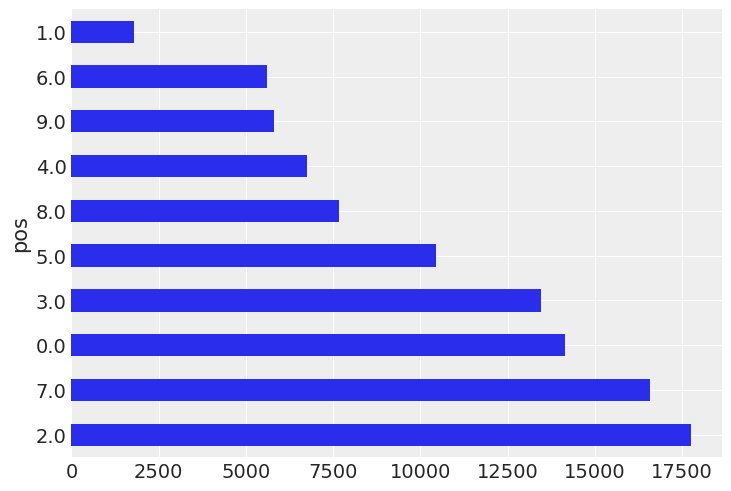

In [122]:
pd.DataFrame({'pos':positions})['pos'].value_counts().plot(kind='barh')

In [123]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
num_islands= 10
counts = np.random.randint(1, 20, size=num_islands)
current_i = 9
current_count = counts[current_i]

for i in range(num_weeks):
    # record current position
    positions[i] = current_i
    # flip coin to generate proposal
    proposal_i = current_i + np.random.choice([-1, 1])
    # loop around the archipelago
    if proposal_i < 0:
        proposal_i = (num_islands-1)
    if proposal_i > (num_islands-1):
        proposal_i = 0
    # move?
    proposal_count = counts[proposal_i]
    prob_move = proposal_count / current_count
    if np.random.uniform() < prob_move:
        current_i = proposal_i
        current_count = proposal_count

<Axes: ylabel='pos'>

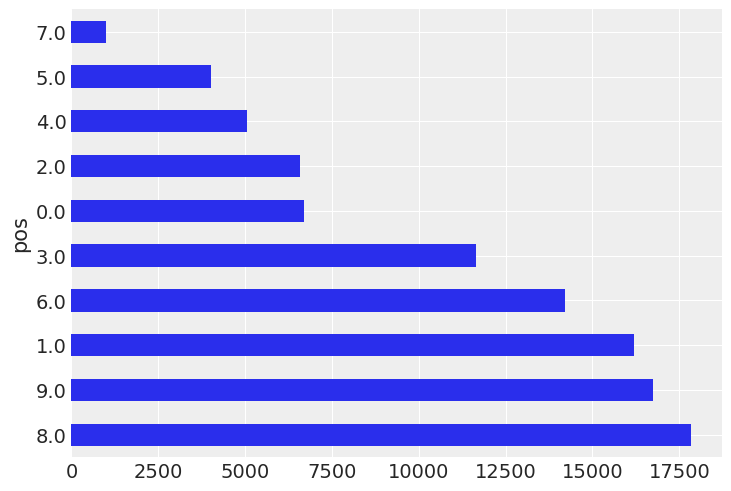

In [124]:
pd.DataFrame({'pos':positions})['pos'].value_counts().plot(kind='barh')

In [125]:
counts

array([ 7, 17,  7, 12,  5,  4, 14,  1, 18, 17], dtype=int32)

9H6.  Modify the Metropolis algorithm code from the chapter to write your own simple MCMC estimator for globe tossing data and model from Chapter 2.

In [144]:
num_tosses = int(1e5)
positions = np.zeros(num_tosses)
num_values= 10
probs = [stats.binom.pmf(7, 10, (i+1)/num_values) for i in range(len(positions))]
current_i = 9
current_count = probs[current_i]

for i in range(num_tosses):
    # record current position
    positions[i] = current_i
    # flip coin to generate proposal
    proposal_i = current_i + np.random.choice([-1, 1])
    # loop around the archipelago
    if proposal_i < 0:
        proposal_i = (num_values-1)
    if proposal_i > (num_values-1):
        proposal_i = 0
    # move?
    proposal_count = probs[proposal_i]
    prob_move = proposal_count / current_count
    if np.random.uniform() < prob_move:
        current_i = proposal_i
        current_count = proposal_count

C:\Users\risto\AppData\Local\Temp\ipykernel_25768\3747730089.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  prob_move = proposal_count / current_count


<Axes: ylabel='pos'>

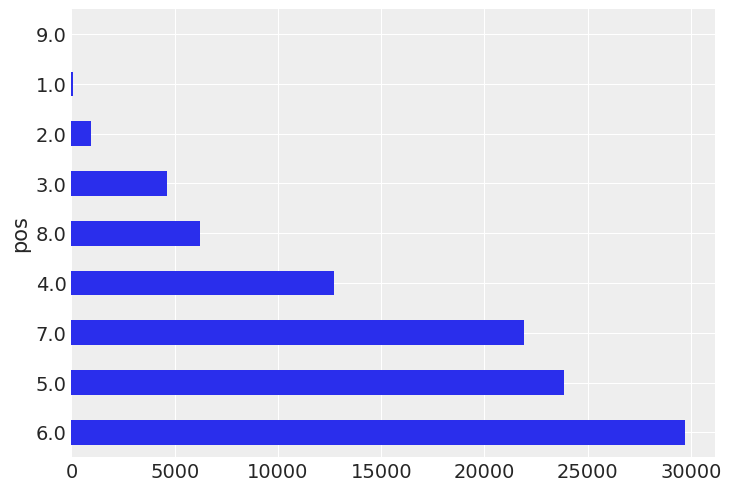

In [145]:
#remember index start from 0  so here 6 is really 7 (70%)
pd.DataFrame({'pos':positions})['pos'].value_counts().plot(kind='barh')

<Axes: >

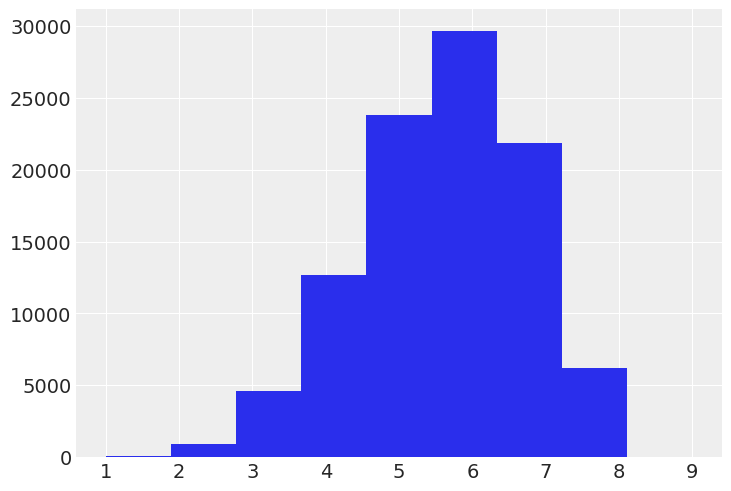

In [151]:
pd.DataFrame({'pos':positions})['pos'].hist(bins=9)

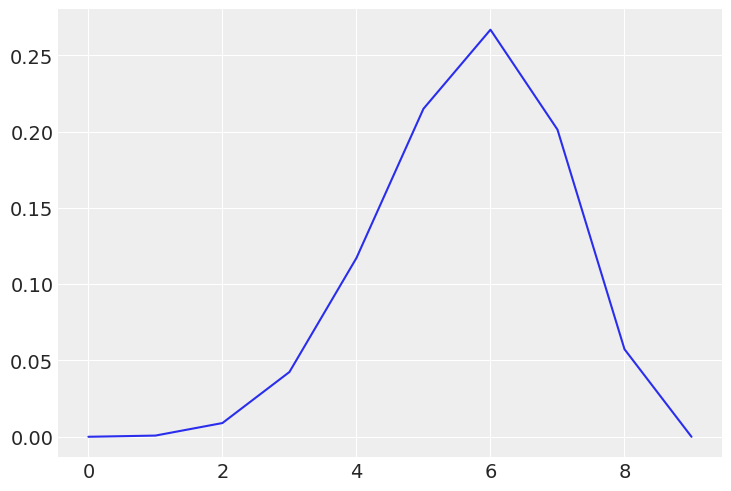

In [143]:
#theoretical distribution
plt.plot(probs)

9H7.  Can you write your own Hamiltonian Monte Carlo algorithm for the globe tossing data, using the R code in the chapter? You will have to write your own functions for the likelihood and gradient, but you can use the HMC2 function.

In [159]:
def calc_U_bin(q, k=6, n=9):
    p = q[0]
    if p <= 0 or p >= 1:
        return np.inf
    return -(k * np.log(p) + (n - k) * np.log(1 - p))

#to use scipy
def calc_U_bin(q, k=6, n=9):
    p = q[0]
    if p <= 0 or p >= 1:
        return np.inf  # log likelihood is undefined outside (0,1)
    log_likelihood = stats.binom.logpmf(k, n, p)
    return -log_likelihood  # Negative log posterior (U)

def grad_U_bin(q, k=6, n=9):
    p = q[0]
    if p <= 0 or p >= 1:
        return np.nan
    return np.array([- (k / p - (n - k) / (1 - p))])


In [160]:
samples = []
p = np.array([0.5])  # initial guess

for _ in range(n_samples):
    result = HMC2(
        U=lambda x, y, q: calc_U_bin(q),
        grad_U=lambda x, y, q: grad_U_bin(q),
        epsilon=step_size,
        L=n_leapfrog_steps,
        current_q=p,
        x=None,
        y=None
    )
    p = result["q"]
    samples.append(p[0])


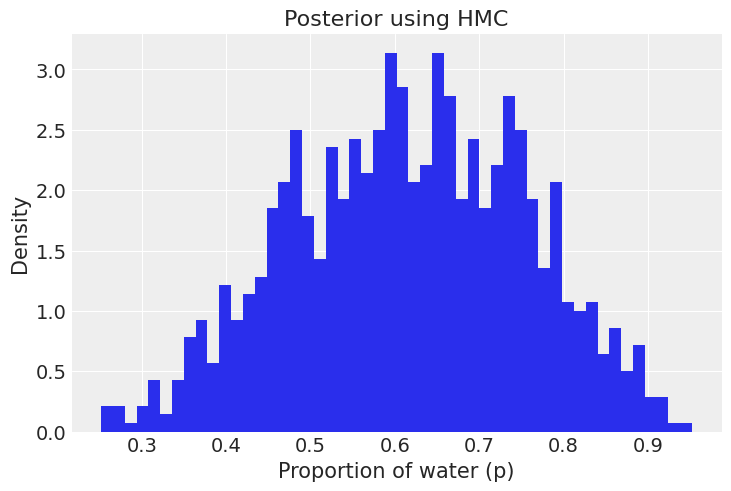

In [161]:
plt.hist(samples, bins=50, density=True)
plt.xlabel("Proportion of water (p)")
plt.ylabel("Density")
plt.title("Posterior using HMC")
plt.show()

In [27]:
%load_ext watermark
%watermark -v -iv -w

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

pandas    : 1.4.2
scipy     : 1.7.3
arviz     : 0.12.1
numpy     : 1.22.1
matplotlib: 3.5.2
pymc      : 4.0.0

Watermark: 2.3.1

